# Open Data Shanghai Hackaton - Air quality experiment

The idea was, given dataset, do something interesting with it, learn insights.

For experiment, Python libraries were used: Pandas, Numpy and Sci-kit Learn

In [1]:
import pandas as pd
import numpy as np

First of all, out of 2 datasets that were given to us, we've decided to:

* use dataset with datespan from May 2000 to January 2013

* from the dataset that contains 1 measurement per day (measures PM2.5, NO2, SO2), we've decided to focus only on PM2.5

* focus only on single city, obviously we've picked Shanghai

We've decided to:

* load, clean the data and try to get some insights

* try to combine it with weather data and try to find corelations between air quality level and weather, in other words use linear regression to try to predict AQI index basing on weather conditions


## Load and clean air quality data

Outside of jupyter notebook we've filtered the AQI data to only those from Shanghai. Resulting file is called shanghai_stations.csv.

Let's load it and remove unnecessary columns

In [2]:
header_names = ['ID','division','areaName','value','pollutant','recordDate','_fetchDate','source']
shangai_raw = pd.read_csv('shanghai_stations.csv', names=header_names)
shangai_raw.head()

,ID,division,areaName,value,pollutant,recordDate,_fetchDate,source
0,24,310000,上海,63,1.0,960134400,1358523225,mep
1,102,310000,上海,64,1.0,960220800,1358523225,mep
2,120,310000,上海,60,1.0,960307200,1358523225,mep
3,138,310000,上海,64,1.0,960393600,1358523225,mep
4,216,310000,上海,122,1.0,960480000,1358523225,mep


In [3]:
shangai_raw_cleaned = shangai_raw.ix[:,['ID','division','value','pollutant','recordDate']]
shangai_raw_cleaned.head()

,ID,division,value,pollutant,recordDate
0,24,310000,63,1.0,960134400
1,102,310000,64,1.0,960220800
2,120,310000,60,1.0,960307200
3,138,310000,64,1.0,960393600
4,216,310000,122,1.0,960480000


Let's see how many rows it contains

In [4]:
shangai_raw_cleaned.shape[0]

4903

Dataset description says that pollutant 1.0 is PM2.5. Let's see how much data there is for it and other pollutants.

In [5]:
shangai_raw_cleaned.groupby('pollutant').count()

,ID,division,value,recordDate
pollutant,,,,
1.0,3227,3227,3227,3227
2.0,121,121,121,121
3.0,12,12,12,12
4.0,22,22,22,22
5.0,83,83,83,83
6.0,9,9,9,9


Let's filter the dataset to only contain those from pollutant equal to 1.0 (which is PM2.5)

In [6]:
filtered_shanghai = shangai_raw_cleaned[shangai_raw_cleaned.pollutant == 1]
filtered_shanghai.head()

,ID,division,value,pollutant,recordDate
0,24,310000,63,1.0,960134400
1,102,310000,64,1.0,960220800
2,120,310000,60,1.0,960307200
3,138,310000,64,1.0,960393600
4,216,310000,122,1.0,960480000


Let's doublecheck how many rows we have now. It should be 3227

In [7]:
filtered_shanghai.shape[0]

3227

The 'recordDate' column is timestamp. Let's use it to create date column

In [8]:
import datetime

filtered_shanghai['date'] = filtered_shanghai['recordDate'].map(lambda d: datetime.datetime.fromtimestamp(d).strftime('%Y-%m-%d'))

/Users/bart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Let's check if it's corect

In [9]:
filtered_shanghai.head(2)

,ID,division,value,pollutant,recordDate,date
0,24,310000,63,1.0,960134400,2000-06-05
1,102,310000,64,1.0,960220800,2000-06-06


Now we can remove unnecesary columns and leave only date and PM2.5 (column 'value'). 

Table below shows first 5 results

In [10]:
filtered_shanghai = filtered_shanghai.ix[:,['value','date']]
filtered_shanghai.head()

,value,date
0,63,2000-06-05
1,64,2000-06-06
2,60,2000-06-07
3,64,2000-06-08
4,122,2000-06-09


## Learning insights from loaded data

So now that we have 'cleaned' Shanghai AQI PM2.5 data from 2000-06-05 to 2013-01-14, let's try to get some insights from it

First, let's just plot all the data to see how it looks

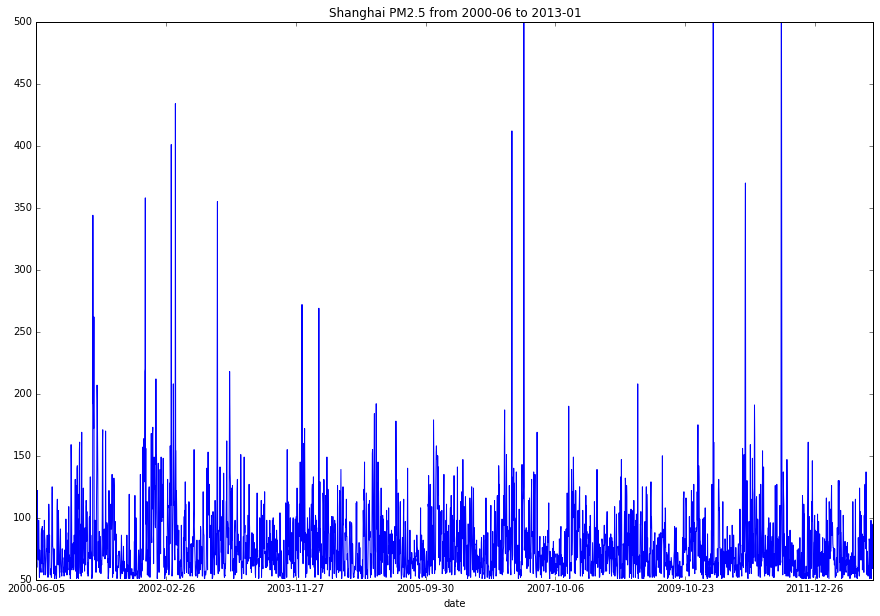

In [11]:
%matplotlib inline

filtered_shanghai.plot(x='date',y='value',figsize=(15,10), legend=False, title='Shanghai PM2.5 from 2000-06 to 2013-01' )

Let's zoom in and show single year: 2012-01 - 2013-01

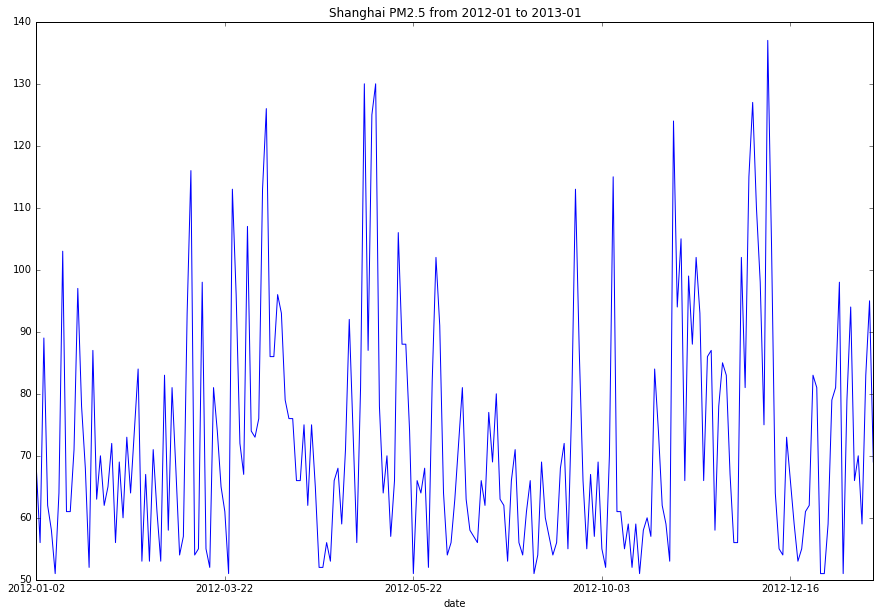

In [250]:
filtered_shanghai[filtered_shanghai['date'] > '2012-01-01'].plot(x='date',y='value',figsize=(15,10), legend=False, title='Shanghai PM2.5 from 2012-01 to 2013-01')

Looks like some data is missing. Let's check that.

In [15]:
len(filtered_shanghai[(filtered_shanghai['date'] >= '2012-01-01') & (filtered_shanghai['date'] < '2013-01-01')])

213

Looks like 2012 is missing quite a lot days (obviously, complete year should  have 365 rows).

Let's check how much data we've missing on average

In [111]:
print("Average, yearly amount of data: %i %%" % ((filtered_shanghai.shape[0]/12) / 365. * 100) )

Average, yearly amount of data: 73 %


Quite a lot missing. Let's define x axis with 365 days and plot all all years to visualize missing data.

In order to split data into years, first we need to add 2 columns: 'year' and 'month_day' which is date without year (e.g. for 'date' 2001-05-10, 'month_day' would be '05-10').

We'll also add column 'month' because it might become usefull later.

In [76]:
filtered_shanghai['month_day'] = filtered_shanghai['date'].str.replace(r'\d{4}-','')
filtered_shanghai['year'] = filtered_shanghai['date'].str.replace(r'-\d{2}-\d{2}','')
filtered_shanghai['month'] = filtered_shanghai['date'].str.extract(r'\d{4}-(\d{2})-\d{2}', expand=False)

In [78]:
filtered_shanghai.head(5)

,value,date,month_day,year,month
0,63,2000-06-05,06-05,2000,06
1,64,2000-06-06,06-06,2000,06
2,60,2000-06-07,06-07,2000,06
3,64,2000-06-08,06-08,2000,06
4,122,2000-06-09,06-09,2000,06


array([<matplotlib.axes._subplots.AxesSubplot object at 0x15a6facd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x15dcc3b10>], dtype=object)

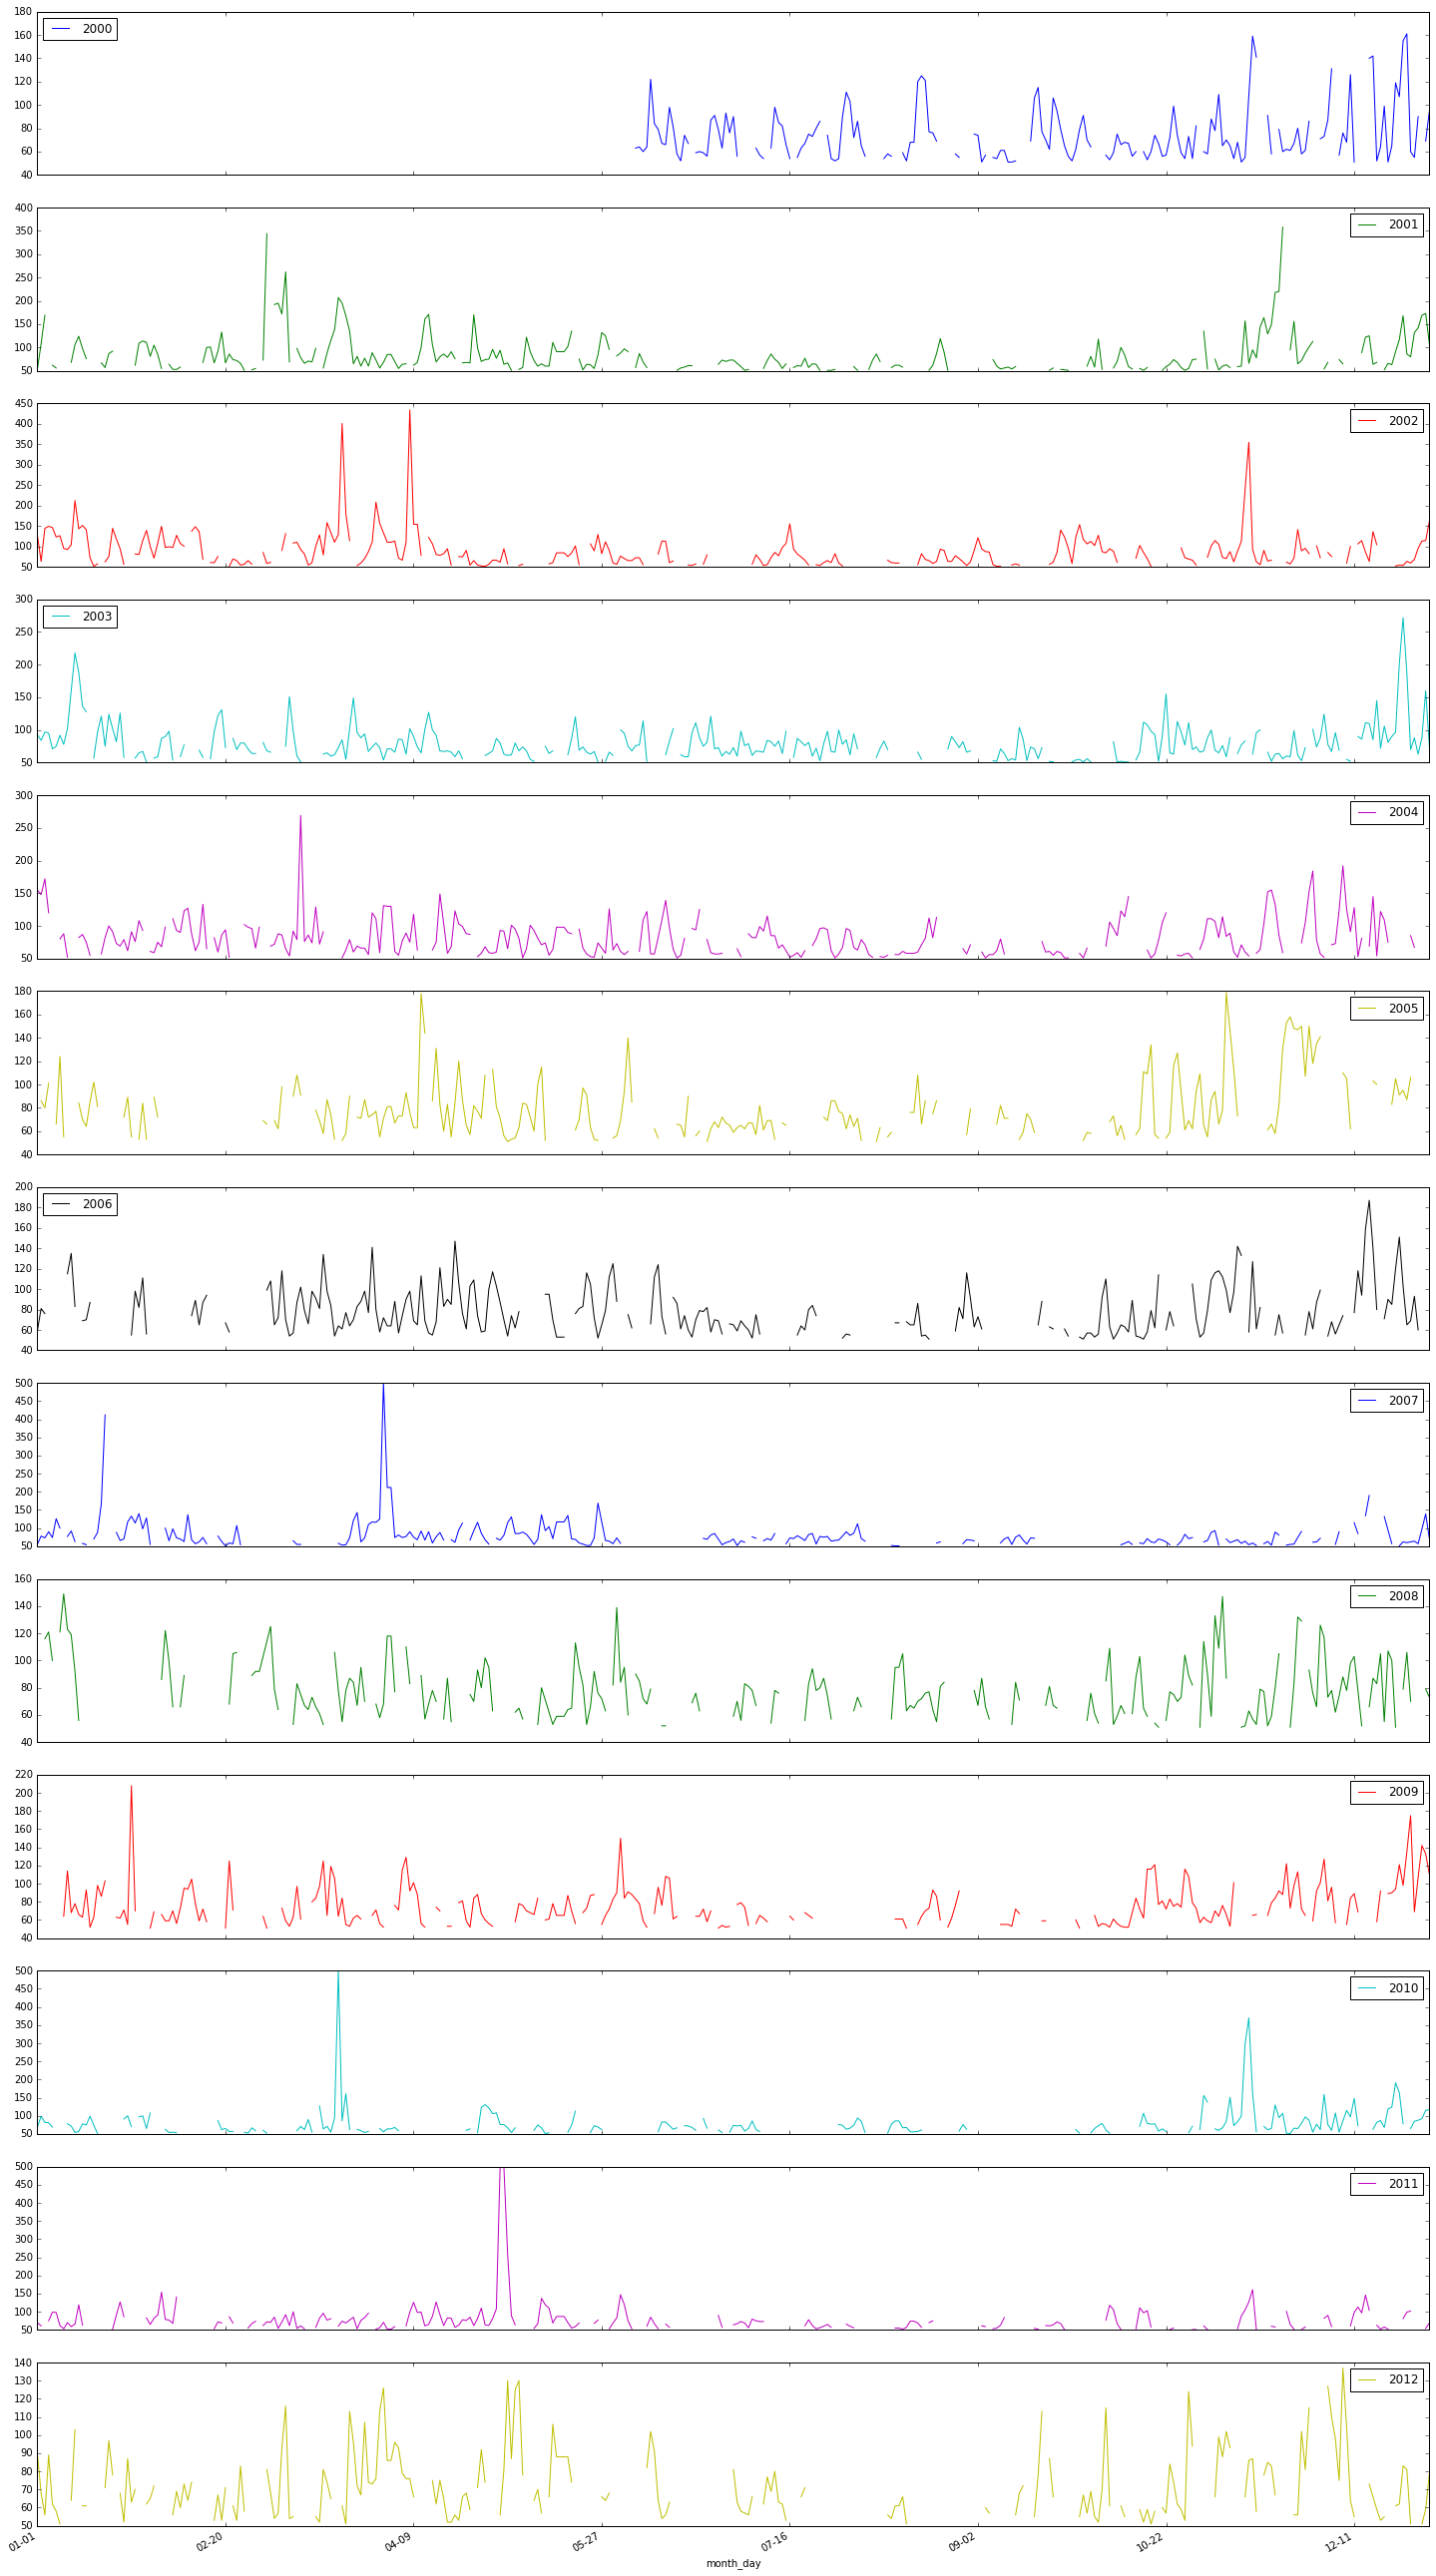

In [100]:
empty_df = pd.DataFrame({'month_day': list(set(list(filtered_shanghai['month_day']))), 'value': np.zeros(366)})
for y in filtered_shanghai.groupby('year'):
    df = pd.DataFrame({'month_day': y[1]['month_day'], y[0]: y[1].value})
    empty_df = pd.merge(empty_df, df , on='month_day', how='left')

merged_columns = [str(y) for y in range(2000,2013)]
merged_columns += ['month_day']
aqi_yearly = empty_df.ix[:,merged_columns].sort_values(by='month_day')

aqi_yearly.plot(x='month_day', figsize=(25,50), subplots=True)

As we can see some years are missing quite a lot of data.

Nothing we can do about it so let's ignore it and try to get some more insights.

** Keep in mind that because of missing data, all results should be taken with grain of salt**

### Plots based on AQI data

Let's plot **mean** values from all years

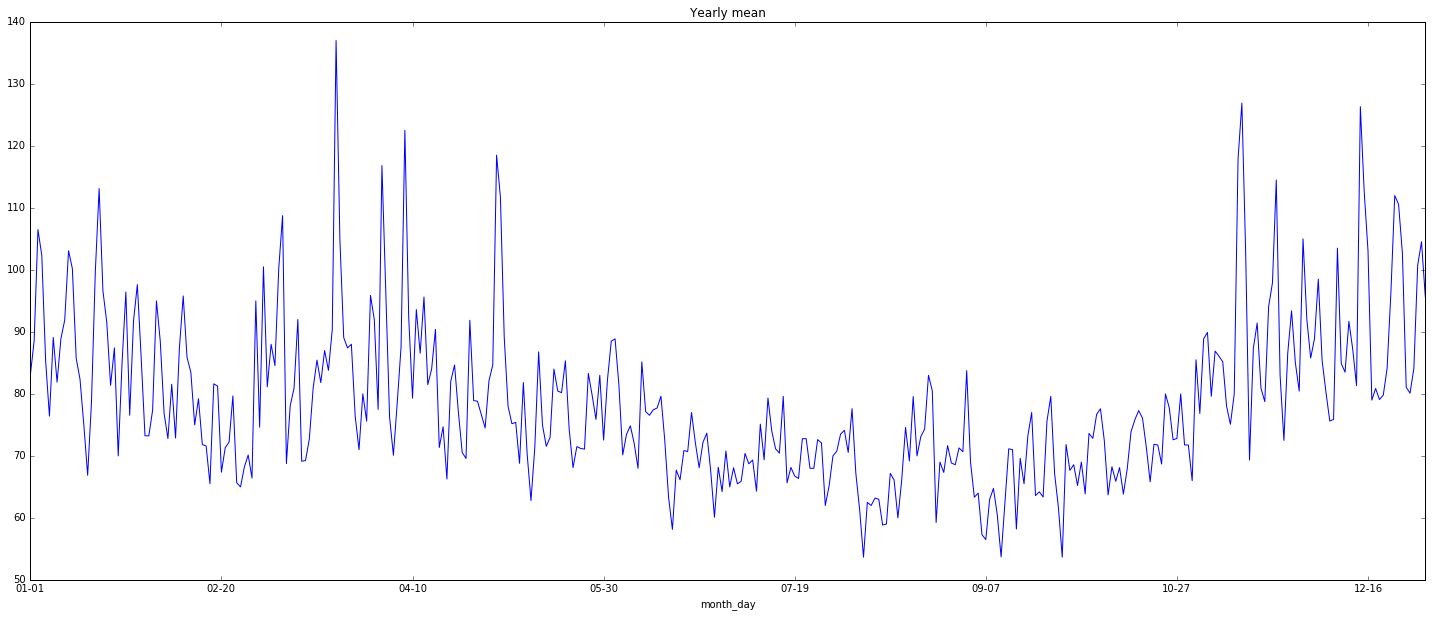

In [110]:
filtered_shanghai.groupby('month_day').mean().plot(figsize=(25,10), legend=False, title='Yearly mean')

Now let's **add minimum and maximum** values

Notice: to make plot more readable, the y axis minimum value has been set to 50 and maximum value to 200

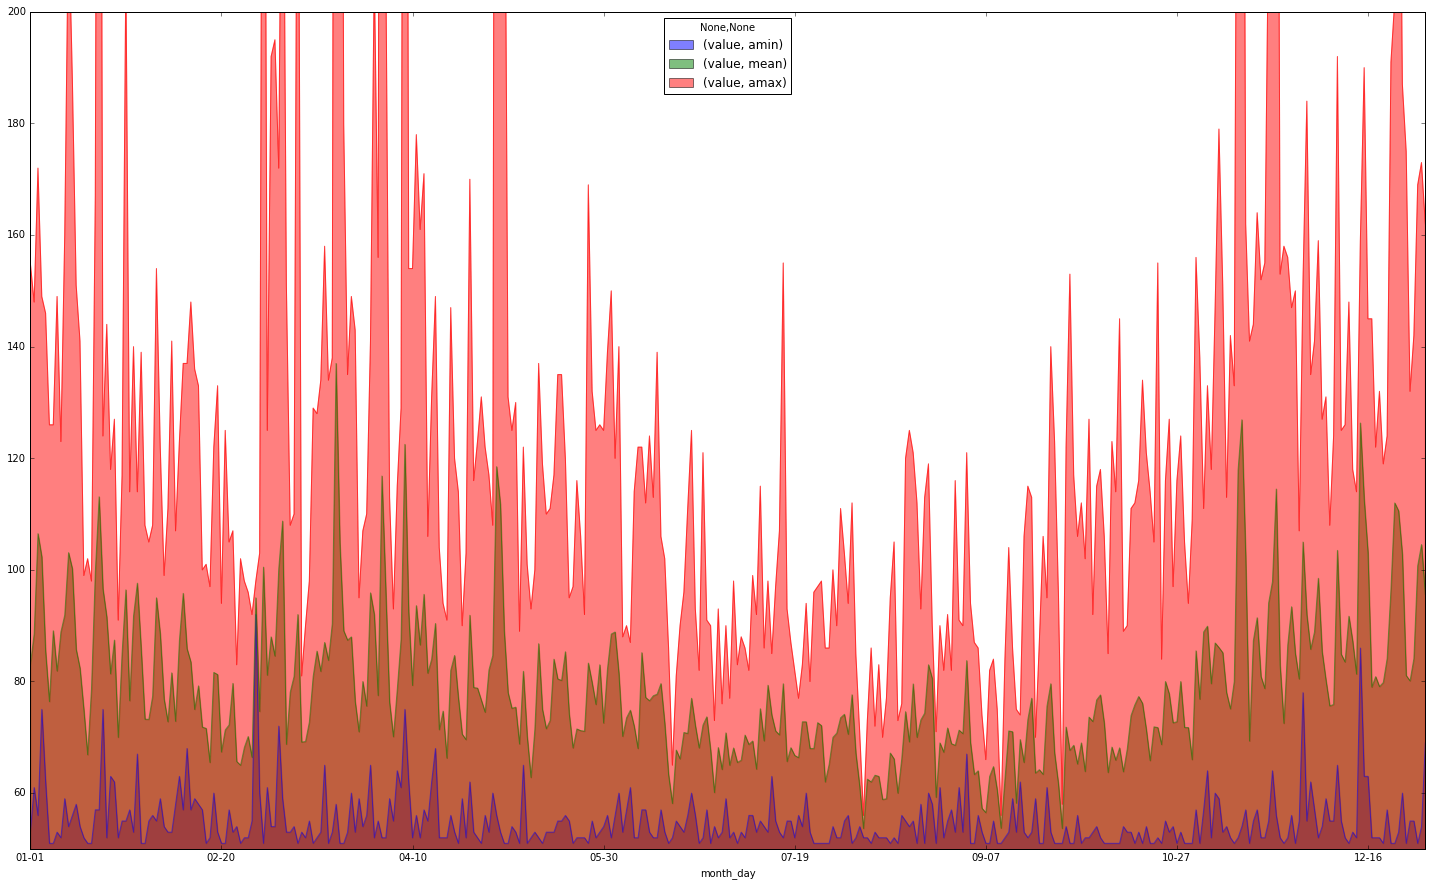

In [227]:
filtered_shanghai.groupby('month_day').agg([np.min, np.mean, np.max]).plot(figsize=(25,15), kind='area', ylim=(50,200), stacked=False)

Looks a little bit unreadable. How about we present the same data in different way

Notice: plot's y max has been set to 170

If you're not sure how to interpret it, read: https://en.wikipedia.org/wiki/Box_plot

(Again, we're missing a lot of data so these results are quite inaccurate)

(40, 170)

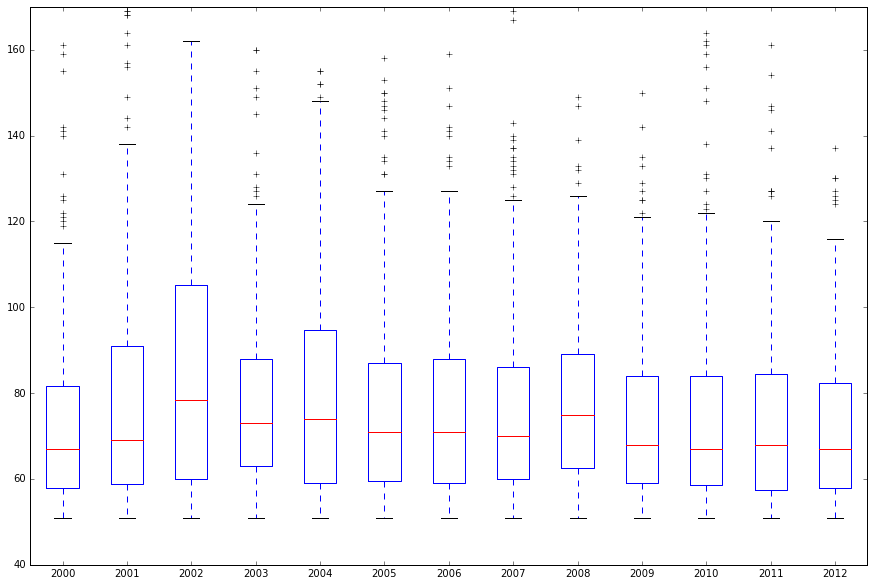

In [116]:
box_plot = aqi_yearly.plot(x='month_day', figsize=(15,10), kind='box')
box_plot.set_ylim(40,170)

What is the distribution from all years? Let's use **histogram**.

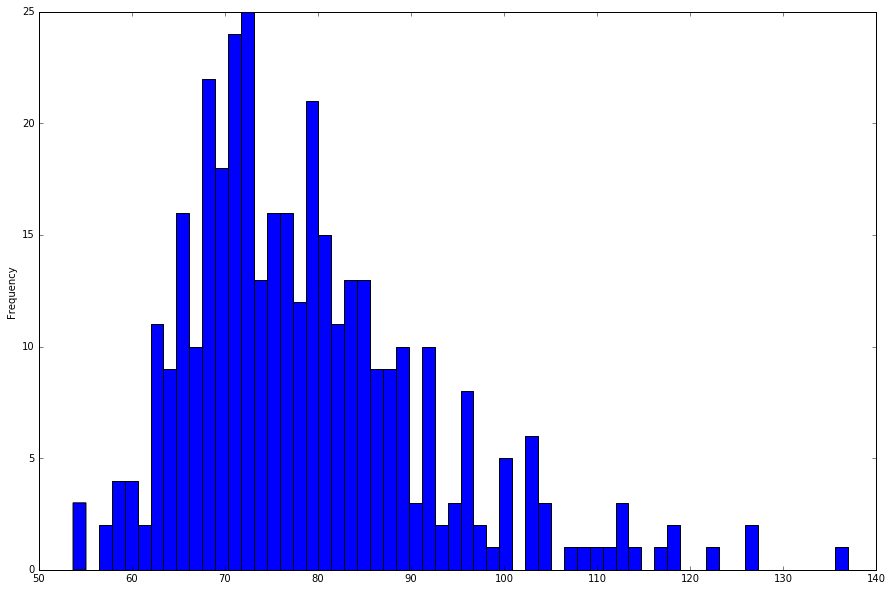

In [213]:
filtered_shanghai.groupby('month_day').mean().plot.hist(figsize=(15,10), bins=60, legend=False)

Let's **split histogram data into individual years**.

To make the histogram more readable, we're cutting it at x == 150 

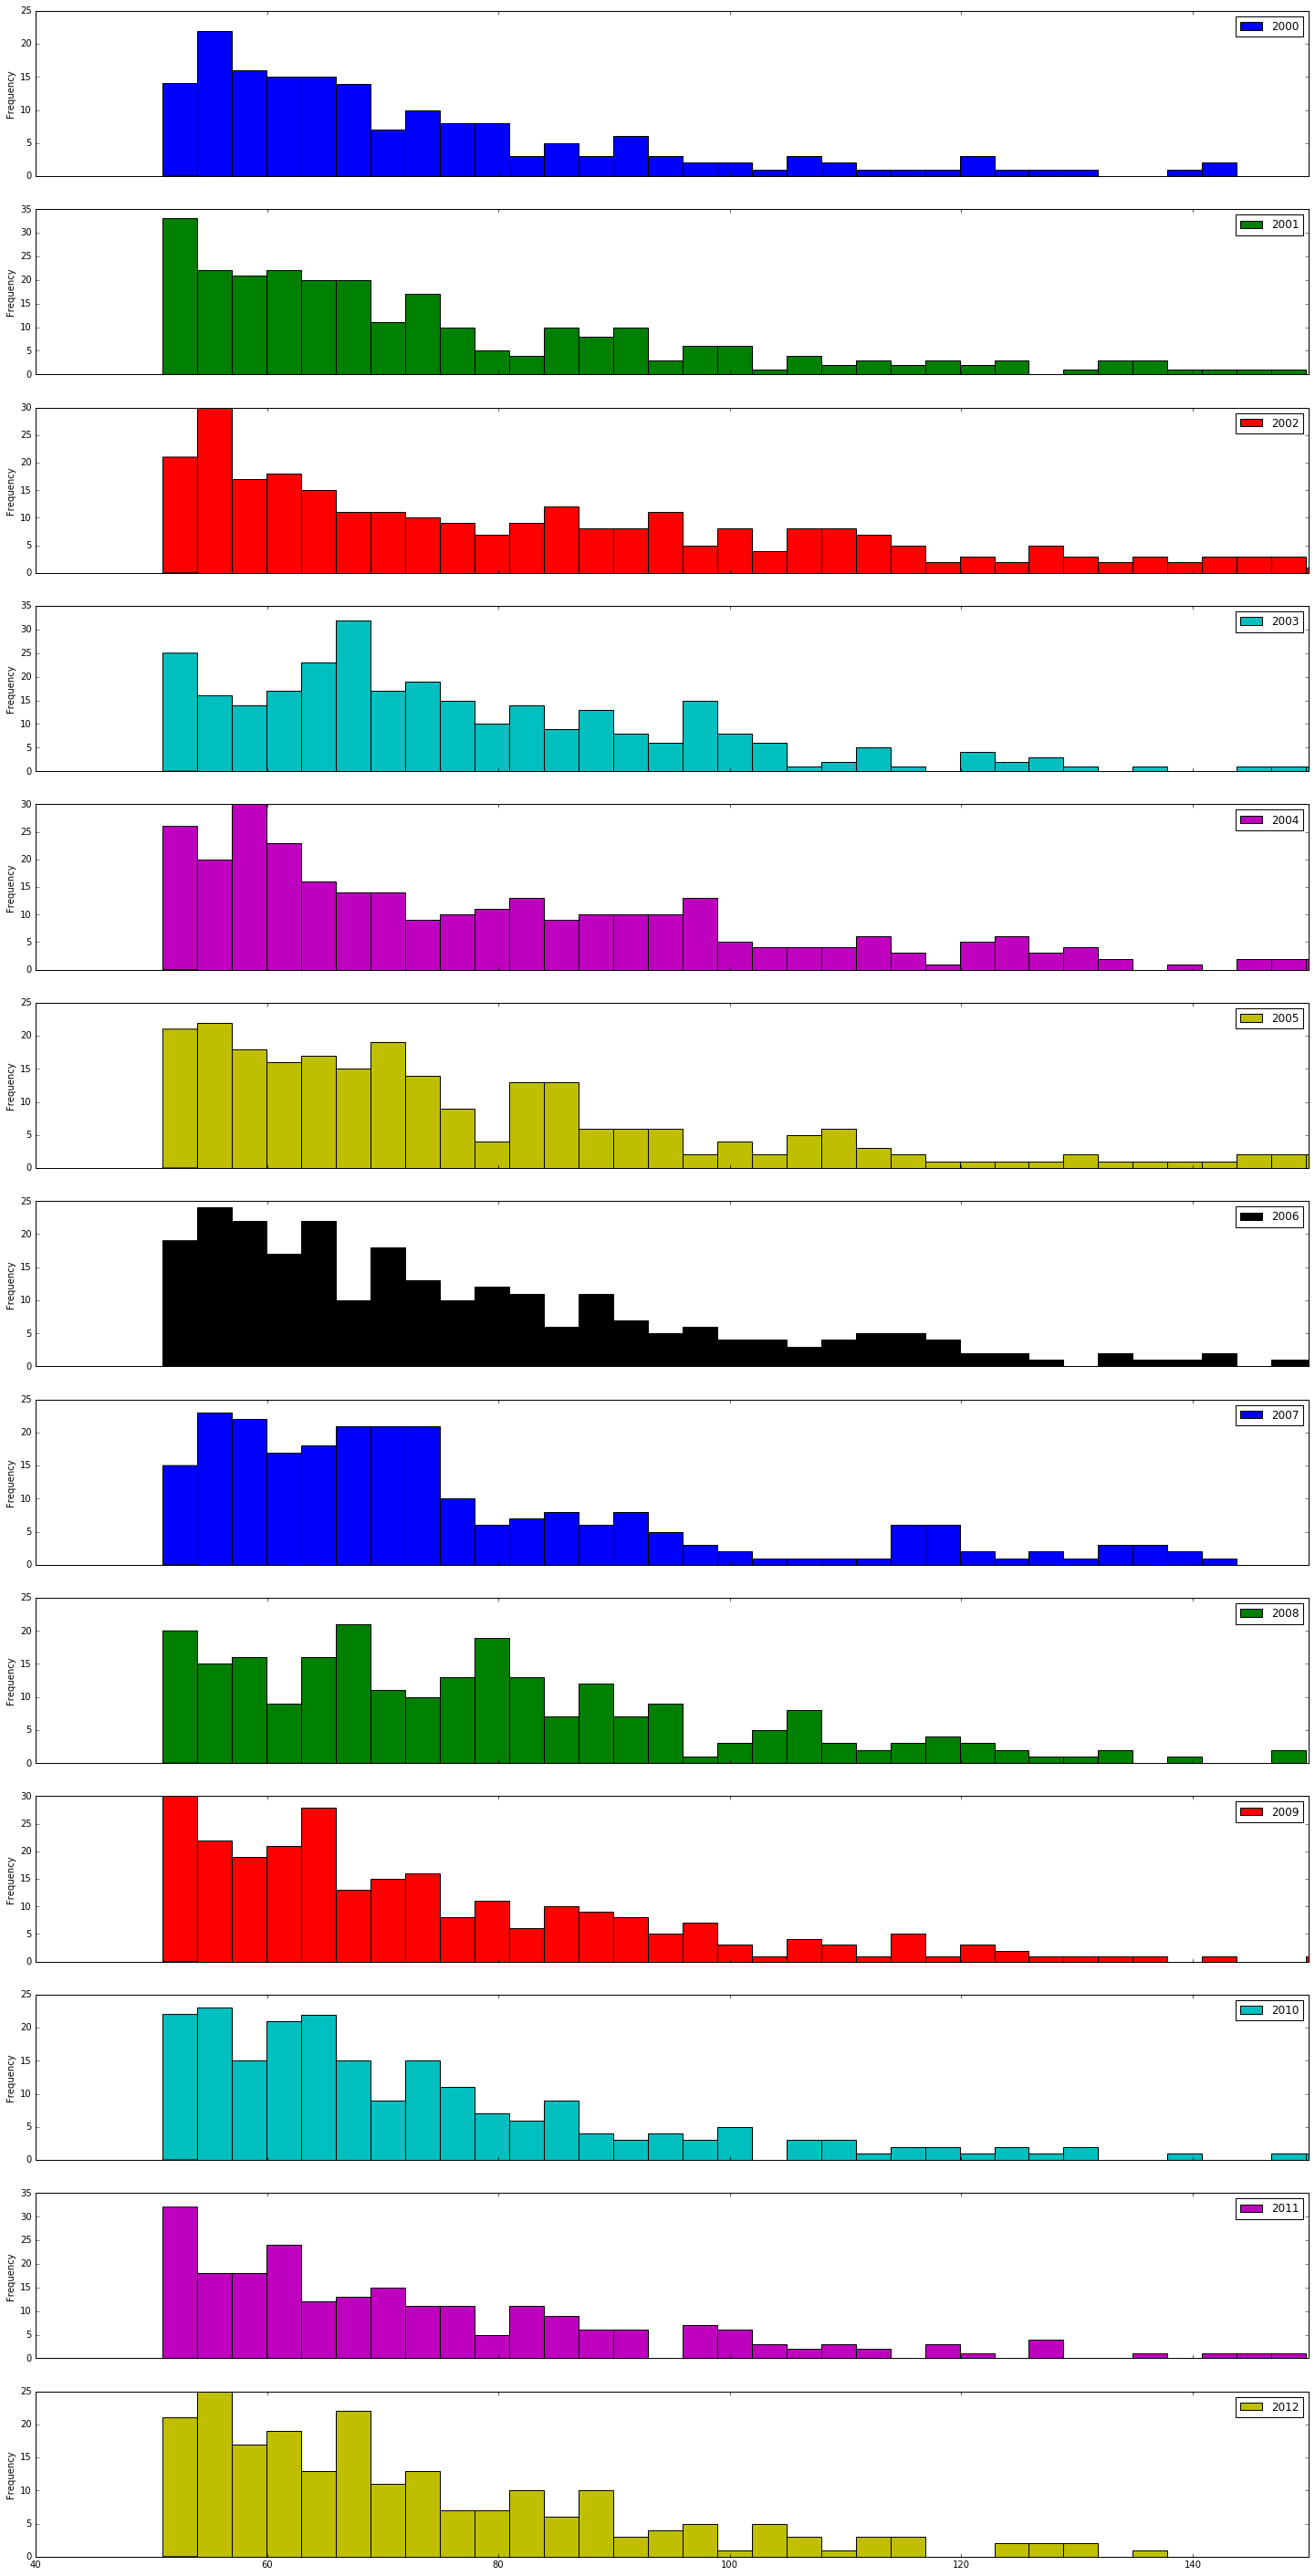

In [109]:
yearly_hist = aqi_yearly.plot(figsize=(25,50), kind='hist', bins=150, subplots=True, xlim=(40,150))

## Loading weather data

The weather dataset has been downloaded from 
Big effort has been made in order to merge it into something readeable (these steps were done outside of jupyter notebook).
Resulting file is called cleanded_sh_weather.csv.

Let's load it ...

In [206]:
shanghai_weather_raw = pd.read_csv('cleanded_sh_weather.csv', sep='\t', index_col=False)
shanghai_weather_raw.head()

,ID,latitude,longitude,altitude,year,month,day,avg_wind_speed(0.1m/s),max_wind_speed(0.1m/s),max_wind_direction,...,control_code_avg_hum,control_code_min_hum,sunlight_time(0.1h),control_code_sun,avg_temperature(0.1C),max_temperature(0.1C),min_temperature(0.1C),control_code_avg_tem,control_code_max_tem,control_code_min_tem
0,58362,3124,12129,60,2000,1,1,18,33,6,...,73,0,0,22,0,114,154,85,0,0
1,58362,3124,12129,60,2000,1,2,40,70,16,...,54,0,0,0,0,76,112,60,0,0
2,58362,3124,12129,60,2000,1,3,30,63,6,...,60,0,0,85,0,75,111,26,0,0
3,58362,3124,12129,60,2000,1,4,20,43,7,...,61,0,0,72,0,119,179,79,0,0
4,58362,3124,12129,60,2000,1,5,18,50,16,...,75,0,0,18,0,125,155,99,0,0


... and pick only needed (and non-empty) columns

In [207]:
columns = ['year','month','day','avg_wind_speed(0.1m/s)','max_wind_speed(0.1m/s)','max_wind_direction','extrem_wind_speed(0.1/s)','extrem_wind_direction','evaporation_small_pan(0.1mm)','evaporation_big_barrel(0.1mm)','avg_ground_temp(0.1C)','max_ground_temp(0.1C)','min_ground_temp(0.1C)','8-20_precipitation(0.1mm)','day_precipitation(0.1mm)','avg_barometric_pressure(0.1hPa)','max_barometric_pressure(0.1hPa)','min_barometric_pressure(0.1hPa)','avg_humidity(1%)','min_humidity(%1)','sunlight_time(0.1h)','avg_temperature(0.1C)','max_temperature(0.1C)','min_temperature(0.1C)']
shanghai_weather_cleanded = shanghai_weather_raw.ix[:,columns]
shanghai_weather_cleanded.head()

,year,month,day,avg_wind_speed(0.1m/s),max_wind_speed(0.1m/s),max_wind_direction,extrem_wind_speed(0.1/s),extrem_wind_direction,evaporation_small_pan(0.1mm),evaporation_big_barrel(0.1mm),...,day_precipitation(0.1mm),avg_barometric_pressure(0.1hPa),max_barometric_pressure(0.1hPa),min_barometric_pressure(0.1hPa),avg_humidity(1%),min_humidity(%1),sunlight_time(0.1h),avg_temperature(0.1C),max_temperature(0.1C),min_temperature(0.1C)
0,2000,1,1,18,33,6,32766,32766,11,5,...,0,0,10191,10216,0,89,0,0,114,154
1,2000,1,2,40,70,16,32766,32766,12,16,...,0,0,10216,10227,0,83,0,0,76,112
2,2000,1,3,30,63,6,32766,32766,22,14,...,0,0,10207,10230,0,75,0,0,75,111
3,2000,1,4,20,43,7,32766,32766,18,8,...,0,0,10176,10199,0,83,0,0,119,179
4,2000,1,5,18,50,16,32766,32766,10,3,...,0,0,10138,10158,0,88,0,0,125,155


Because we want to merge this dataset with weather dataset, we need to create 'date' column.

We will also create 'week_of_year' column which will become useful later

In [208]:
shanghai_weather_cleanded['date'] = shanghai_weather_cleanded.apply(lambda row: datetime.date(row['year'].astype(int), row['month'].astype(int), row['day'].astype(int)).strftime('%Y-%m-%d'), axis=1)
shanghai_weather_cleanded['week_of_year'] = shanghai_weather_cleanded.apply(lambda row: datetime.datetime.strptime(row['date'], '%Y-%m-%d').isocalendar()[1], axis=1 )
shanghai_weather_cleanded.head()

,year,month,day,avg_wind_speed(0.1m/s),max_wind_speed(0.1m/s),max_wind_direction,extrem_wind_speed(0.1/s),extrem_wind_direction,evaporation_small_pan(0.1mm),evaporation_big_barrel(0.1mm),...,max_barometric_pressure(0.1hPa),min_barometric_pressure(0.1hPa),avg_humidity(1%),min_humidity(%1),sunlight_time(0.1h),avg_temperature(0.1C),max_temperature(0.1C),min_temperature(0.1C),date,week_of_year
0,2000,1,1,18,33,6,32766,32766,11,5,...,10191,10216,0,89,0,0,114,154,2000-01-01,52
1,2000,1,2,40,70,16,32766,32766,12,16,...,10216,10227,0,83,0,0,76,112,2000-01-02,52
2,2000,1,3,30,63,6,32766,32766,22,14,...,10207,10230,0,75,0,0,75,111,2000-01-03,1
3,2000,1,4,20,43,7,32766,32766,18,8,...,10176,10199,0,83,0,0,119,179,2000-01-04,1
4,2000,1,5,18,50,16,32766,32766,10,3,...,10138,10158,0,88,0,0,125,155,2000-01-05,1


For some reason column 'avg_temperature(0.1C)' is almost empty so we need to fix it by taking average from column 'max_temperature(0.1C)' and 'min_temperature(0.1C)' and change scale from 0.1 celsius to 1 celsius

Same operation has to be done for 'avg_barometric_pressure(0.1hPa)'

In [209]:
shanghai_weather_cleanded['avg_temperature(C)'] = (shanghai_weather_cleanded['max_temperature(0.1C)'] +
                                                   shanghai_weather_cleanded['max_temperature(0.1C)']) / 2 / 10.

shanghai_weather_cleanded['avg_barometric_pressure(hPa)'] = (shanghai_weather_cleanded['max_barometric_pressure(0.1hPa)'] +
                                                   shanghai_weather_cleanded['min_barometric_pressure(0.1hPa)']) / 2 / 10.

shanghai_weather_cleanded['day_precipitation(mm)'] = shanghai_weather_cleanded['day_precipitation(0.1mm)'] / 10.

Some columns contain no data (e.g. 'shanghai_weather_cleanded'), let's remove them and only keep those which have value for us

In [210]:
final_columns = ['date', 'week_of_year', 'avg_wind_speed(0.1m/s)','max_wind_direction','day_precipitation(mm)','avg_barometric_pressure(hPa)','min_humidity(%1)','avg_temperature(C)']
shanghai_weather_cleanded = shanghai_weather_cleanded.ix[:,final_columns]
shanghai_weather_cleanded.head()

,date,week_of_year,avg_wind_speed(0.1m/s),max_wind_direction,day_precipitation(mm),avg_barometric_pressure(hPa),min_humidity(%1),avg_temperature(C)
0,2000-01-01,52,18,6,0.0,1020.35,89,11.4
1,2000-01-02,52,40,16,0.0,1022.15,83,7.6
2,2000-01-03,1,30,6,0.0,1021.85,75,7.5
3,2000-01-04,1,20,7,0.0,1018.75,83,11.9
4,2000-01-05,1,18,16,0.0,1014.80,88,12.5


#### Weather data basic stats

In [202]:
shanghai_weather_cleanded.shape

(6057, 8)

In [203]:
shanghai_weather_cleanded.tail(1)

,date,week_of_year,avg_wind_speed(0.1m/s),max_wind_direction,day_precipitation(mm),avg_barometric_pressure(hPa),min_humidity(%1),avg_temperature(C)
6056,2016-07-31,30,33,6,0.0,1009.1,71,30.9


**Weather data basic stats:**

* 6057 days 

* first day is 2000-01-01

* last day is 2016-07-31

Let's plot data from few columns.

But first we need to add 'month_day' column.

In [211]:
shanghai_weather_cleanded['month_day'] = shanghai_weather_cleanded['date'].str.replace(r'\d{4}-','')

### Plots based on weather data

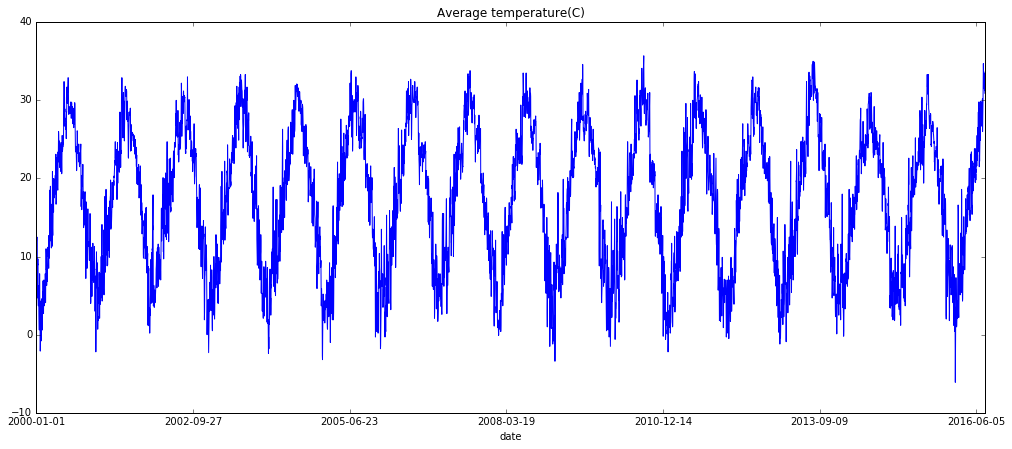

In [269]:
shanghai_weather_cleanded.plot(x='date', y='avg_temperature(C)', figsize=(17,7), legend=False, title='Average temperature(C)')

Quite unreadable, let's change it into (2000/01 - 2016/07) yearly average

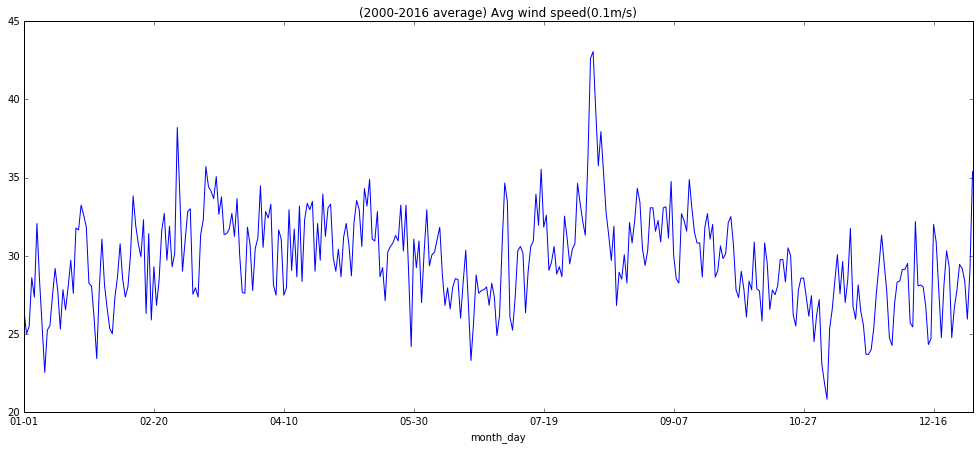

In [268]:
shanghai_weather_cleanded.groupby('month_day').mean().plot(y='avg_wind_speed(0.1m/s)', figsize=(17,7), legend=False, title='(2000-2016 average) Avg wind speed(0.1m/s)')

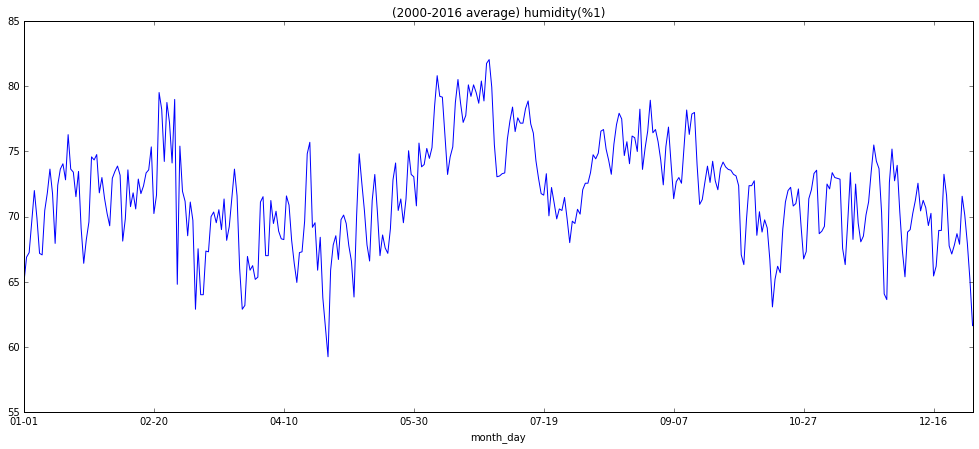

In [267]:
shanghai_weather_cleanded.groupby('month_day').mean().plot(y='min_humidity(%1)', figsize=(17,7), legend=False, title='(2000-2016 average) humidity(%1)')

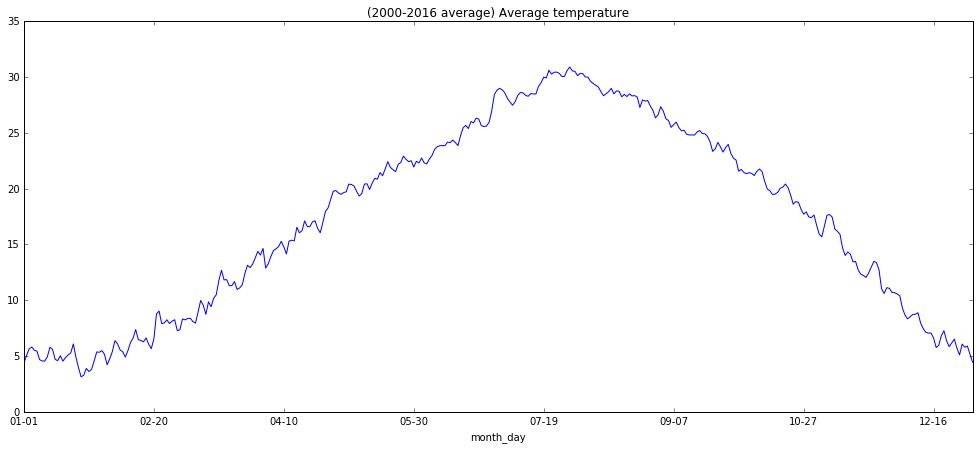

In [266]:
shanghai_weather_cleanded.groupby('month_day').mean().plot(y='avg_temperature(C)', figsize=(17,7), legend=False, title='(2000-2016 average) Average temperature')

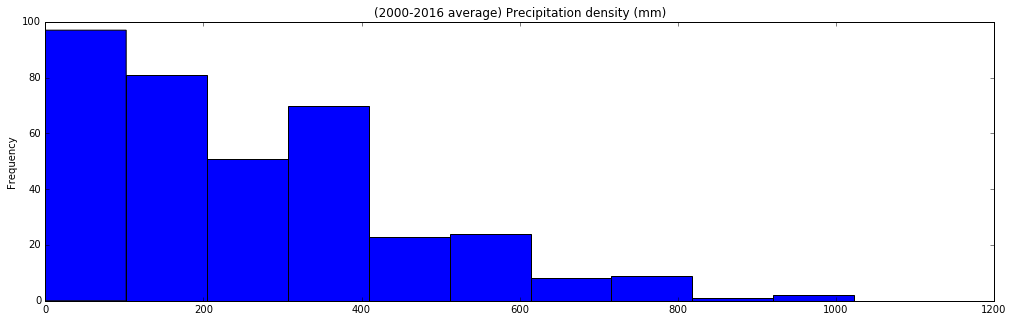

In [709]:
shanghai_weather_cleanded.groupby('month_day').mean().plot(kind='hist', y='day_precipitation(mm)', bins=10,
                                                           figsize=(17,5), legend=False, 
                                                           title='(2000-2016 average) Precipitation density (mm)' )

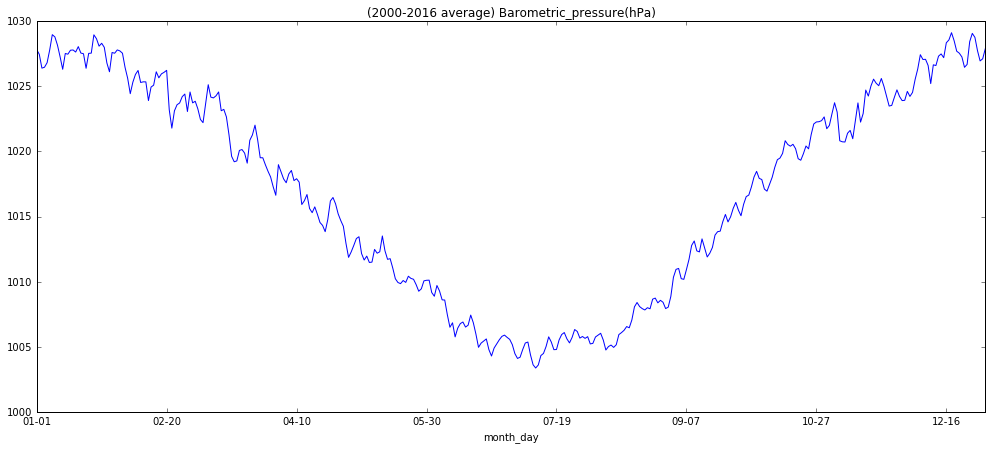

In [277]:
shanghai_weather_cleanded.groupby('month_day').mean().plot(y='avg_barometric_pressure(hPa)', figsize=(17,7), legend=False, title='(2000-2016 average) Barometric_pressure(hPa)')

## Merging datasets

Cleaned datasets are:
* shanghai_weather_cleanded - weather data

* filtered_shanghai - air quality data

Let's merge them

In [878]:
merged_aqi_weather_df = pd.merge(shanghai_weather_cleanded, filtered_shanghai, on=['date'])
merged_aqi_weather_df.head()

,date,week_of_year,avg_wind_speed(0.1m/s),max_wind_direction,day_precipitation(mm),avg_barometric_pressure(hPa),min_humidity(%1),avg_temperature(C),month_day_x,value,month_day_y,year,month
0,2000-06-05,23,28,4,0.0,1009.80,84,20.9,06-05,63,06-05,2000,06
1,2000-06-06,23,30,6,0.0,1009.55,65,23.1,06-06,64,06-06,2000,06
2,2000-06-07,23,20,6,0.0,1007.40,72,24.6,06-07,60,06-07,2000,06
3,2000-06-08,23,28,16,8.9,1002.35,93,23.2,06-08,64,06-08,2000,06
4,2000-06-09,23,25,11,0.0,1007.10,83,23.0,06-09,122,06-09,2000,06


Our AQI data had 3227 rows and our merged data should have the same number of rows. Let's check that.

In [879]:
merged_aqi_weather_df.shape[0]

3227

### Cleaning merged dataset

There was some incorrect data in preciptation column, for 127 rows it contained very big value equal to 3270.0 .

It has been set to 0

In [880]:
merged_aqi_weather_df[merged_aqi_weather_df['day_precipitation(mm)'] == 3270.0] = 0.0

Also there was 274 empty rows which were removed

In [881]:
merged_aqi_weather_df = merged_aqi_weather_df[merged_aqi_weather_df['date'] != 0]

Now cleaned dataset has rows:

In [882]:
merged_aqi_weather_df.shape[0]

2980

## Building basic predicton model

As mentioned before, we're going to use linear regression to try to predict AQI index basing on weather conditions

In [883]:
X_columns = ['week_of_year', 'avg_wind_speed(0.1m/s)','max_wind_direction', 'day_precipitation(mm)','avg_barometric_pressure(hPa)', 'min_humidity(%1)','avg_temperature(C)', 'month']  

X = merged_aqi_weather_df.ix[:,X_columns]
y = merged_aqi_weather_df['value']

Double-checking sizes of "input" and "output"

In [884]:
X.shape

(2980, 8)

In [885]:
y.shape

(2980,)

Let's also check first 5 rows of "input" and "output"

In [886]:
X.head()

,week_of_year,avg_wind_speed(0.1m/s),max_wind_direction,day_precipitation(mm),avg_barometric_pressure(hPa),min_humidity(%1),avg_temperature(C),month
0,23.0,28.0,4.0,0.0,1009.80,84.0,20.9,06
1,23.0,30.0,6.0,0.0,1009.55,65.0,23.1,06
2,23.0,20.0,6.0,0.0,1007.40,72.0,24.6,06
3,23.0,28.0,16.0,8.9,1002.35,93.0,23.2,06
4,23.0,25.0,11.0,0.0,1007.10,83.0,23.0,06


In [887]:
y.head()

0     63.0
1     64.0
2     60.0
3     64.0
4    122.0
Name: value, dtype: float64

Now we're going to normalize the data and split it into training and test sets

In [888]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

In [889]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(normalize=True) 

Now let's train out model

In [890]:
%time linreg.fit(X_train, y_train)

CPU times: user 2.63 ms, sys: 838 µs, total: 3.47 ms
Wall time: 1.8 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

... and make prediction using test data

In [891]:
y_predict = linreg.predict(X_test)

Let's compare our model's predictions vs. test data.

Remember, the numbers represent PM2.5 values

In [892]:
import math

score_df = pd.DataFrame(data={'Our test data': list(y_test), 'What our model predicted': list(y_predict)})
score_df.head(20)

,Our test data,What our model predicted
0,76.0,80.238791
1,124.0,89.387780
2,61.0,77.447753
3,80.0,75.624888
4,56.0,79.194893
5,75.0,74.751426
6,76.0,69.331279
7,83.0,81.226367
8,53.0,62.179429
9,114.0,79.828000


Let's check how much on average we're off

In [893]:
score = score_df.apply(lambda r: math.sqrt( (r['Our test data'] - r['What our model predicted'])**2 ), axis=1 )
score.mean()

18.889175627956043

We are on average almost 19 points wrong. This is really bad. 

What is the model's score?

In [895]:
linreg.score(X_test, y_test)

0.10859159234358751

So far I didn't have time to improve the model, but the initial low score might indicate that either there is not enough data or correlation between selected AQI and weather data is not strong. 

I've decided to leave it as it is for now and have a look again in future.